In [1]:
# import warnings
# warnings.filterwarnings("ignore")

import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import scipy
import scipy.signal
import os, os.path

from datetime import date
import datetime
import time

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import seaborn as sb

import sys
import io

# to move files from one directory to another
import shutil


import yfinance as yf
from nasdaq_stock import nasdaq_stock as nasdaq_stock
import requests

from pylab import rcParams

# search path for modules
# look @ https://stackoverflow.com/questions/67631/how-to-import-a-module-given-the-full-path
sys.path.append('../')
import cycles_core as cc
import cycles_plot_core as cpc

## Simple mixture of low frequency Fourier components, messed up by very high frequency ''noise''. Smoothing versus low pass filtering example.

   - <b> Create a true signal</b>
   - <b> Create noisy signal</b>
   - <b> Find FFT of true and noisy signal</b>
   - <b> Filter the noisy signals</b>

In [2]:
from numpy.fft import rfft, irfft, rfftfreq, ifft
from scipy import fft
import pandas as pd

In [3]:
plot_dir = "/Users/hn/Documents/cyclesFigs/"

# Set the plotting style

In [4]:
size = 15
title_FontSize = 10
legend_FontSize = 8
tick_FontSize = 12
label_FontSize = 14

params = {'legend.fontsize': 'large',
          'figure.figsize': (6, 4),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size * 0.75,
          'ytick.labelsize': size * 0.75,
          'axes.titlepad': 10}


#
#  Once set, you cannot change them, unless restart the notebook
#
plt.rc('font', family = 'Palatino')
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['ytick.labelleft'] = False
plt.rcParams.update(params)
# pylab.rcParams.update(params)
plt.rc('text', usetex=True)

In [5]:
#
#  Once set, you cannot change them, unless restart the notebook
#
# plt.rc('font', family='serif')
# plt.rc('text', usetex=True)
# plt.rc('xtick', labelsize='x-small')
# plt.rc('ytick', labelsize='x-small')

# From [This website](https://realpython.com/python-scipy-fft/#practical-example-remove-unwanted-noise-from-audio)

# Generate True and Noisy Signals

In [6]:
def generate_sine_and_Cosie_wave(freq, sample_rate, duration):
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    frequencies = x * freq
    y = np.sin((2 * np.pi) * frequencies) + np.cos((3 * np.pi) * frequencies)
    
    return x, y

In [7]:
SAMPLE_RATE = 44100
DURATION = 3

In [8]:
_, nice_tone_2  = generate_sine_and_Cosie_wave(freq = 2,  sample_rate = SAMPLE_RATE, duration = DURATION)
_, nice_tone_10 = generate_sine_and_Cosie_wave(freq = 10,  sample_rate = SAMPLE_RATE, duration = DURATION)
_, nice_tone_20 = generate_sine_and_Cosie_wave(freq = 20,  sample_rate = SAMPLE_RATE, duration = DURATION)
_, nice_tone_30 = generate_sine_and_Cosie_wave(freq = 30,  sample_rate = SAMPLE_RATE, duration = DURATION)
_, nice_tone_40 = generate_sine_and_Cosie_wave(freq = 40, sample_rate = SAMPLE_RATE, duration = DURATION)


_, noise_tone_100 = generate_sine_and_Cosie_wave(freq = 100, sample_rate = SAMPLE_RATE, duration = DURATION)
_, noise_tone_200 = generate_sine_and_Cosie_wave(freq = 200, sample_rate = SAMPLE_RATE, duration = DURATION)
_, noise_tone_300 = generate_sine_and_Cosie_wave(freq = 300, sample_rate = SAMPLE_RATE, duration = DURATION)
_, noise_tone_400 = generate_sine_and_Cosie_wave(freq = 400, sample_rate = SAMPLE_RATE, duration = DURATION)
_, noise_tone_500 = generate_sine_and_Cosie_wave(freq = 500, sample_rate = SAMPLE_RATE, duration = DURATION)
_, noise_tone_600 = generate_sine_and_Cosie_wave(freq = 600, sample_rate = SAMPLE_RATE, duration = DURATION)

noise_tone_100 = noise_tone_100 * 0.4
noise_tone_200 = noise_tone_200 * 0.4
noise_tone_300 = noise_tone_300 * 0.4
noise_tone_400 = noise_tone_400 * 0.4
noise_tone_500 = noise_tone_500 * 0.4
noise_tone_600 = noise_tone_600 * 0.4

nice_tone = nice_tone_2 + nice_tone_10 + nice_tone_20 + \
            nice_tone_30 + nice_tone_40 

noisy_tone = nice_tone + noise_tone_100 + noise_tone_200 + \
             noise_tone_300 + noise_tone_400 + noise_tone_500 + \
             noise_tone_600

print (len(nice_tone))

132300


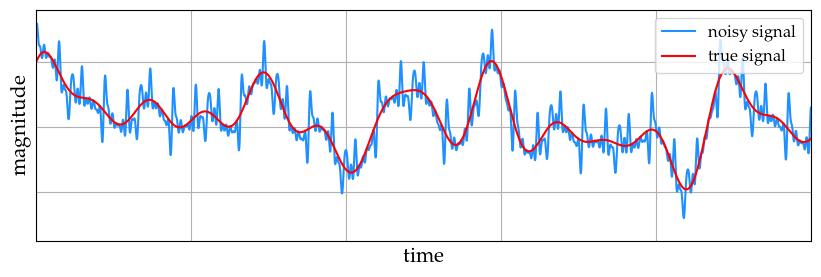

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 3)
ax.grid(True)

#######

ax.plot(noisy_tone, '-', label = 'noisy signal', c = "dodgerblue")
ax.plot(nice_tone, '-', label = 'true signal', c='r') #  linewidth=2,

ax.set_xlabel('time') # labelpad=20); # fontsize = label_FontSize,
ax.set_ylabel('magnitude') # , labelpad=20); # fontsize = label_FontSize,

ax.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax.legend(loc="upper right");
ax.grid(True);

plt.xlim([0, 10000])

file_name = plot_dir + "noisy_sineCosine_atOnce.pdf"
# plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)

<Figure size 600x400 with 0 Axes>

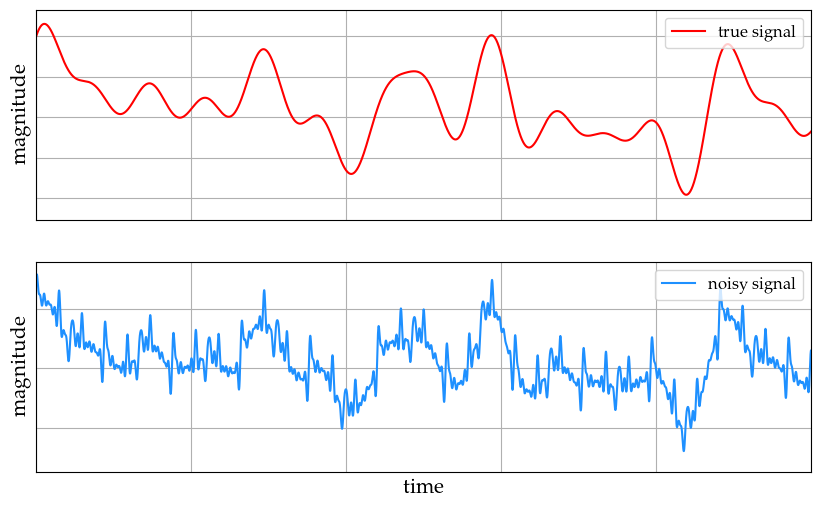

In [10]:
# plt.subplots_adjust(left=0, bottom=0, right=1.1, top=0.9, wspace=0, hspace=0)
# plt.subplots_adjust(wspace=.1, hspace = 0.5)
plt.subplots_adjust(right=1.5, top=1.1)

##########################################################################################
fig, axs = plt.subplots(2, 1, figsize=(10, 6),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.2, 'wspace': .1});

(ax1, ax2) = axs;
ax1.grid(True); ax2.grid(True)


#######
#######  subplot 1
#######
ax1.plot(nice_tone, '-', label = 'true signal', c='r') #  linewidth=2,
ax1.set_ylabel('magnitude') # , labelpad=20); # fontsize = label_FontSize,

ax1.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
ax1.tick_params(axis='x', which='major') #, labelsize = tick_FontSize) # 
ax1.legend(loc="upper right");
ax1.grid(True);

#######
#######  subplot 2
#######
ax2.plot(noisy_tone, '-', label = 'noisy signal', c = "dodgerblue")

ax2.set_xlabel('time') # , labelpad = 20); # fontsize = label_FontSize,
ax2.set_ylabel('magnitude') # , labelpad = 20); # fontsize = label_FontSize,

ax2.tick_params(axis = 'y', which = 'major') # , labelsize = tick_FontSize) #
ax2.tick_params(axis = 'x', which = 'major') #, labelsize = tick_FontSize) # 

ax2.legend(loc="upper right");
ax2.grid(True);

plt.xlim([0, 10000])


file_name = plot_dir + "noisy_sineWave_1Cosine.pdf"
# plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)

# MF Style

### Define Class and plotting function

<Figure size 600x400 with 0 Axes>

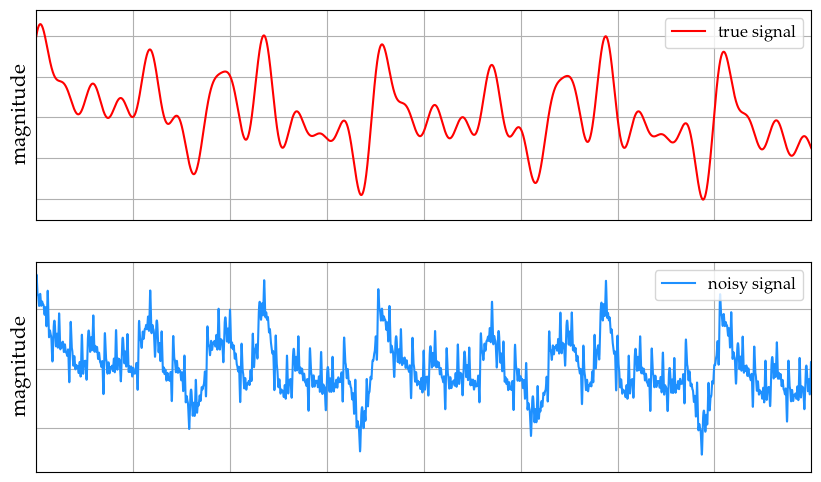

In [11]:
first_twoSubplots_obj = cpc.two_curves_2subplots_class(x1 = np.arange(len(nice_tone)), 
                                                       y1 = nice_tone, 
                                                       leg1 = "true signal", 
                                               
                                                       x2 = np.arange(len(noisy_tone)), 
                                                       y2 = noisy_tone, 
                                                       leg2 = "noisy signal" , 
                                               
                                                       x_label = "time", 
                                                       y_label = "magnitude", 
                                                       x_limits = [0, 20000], 
                                                       y_limits = [-4, 4])


cpc.plot_TwoSubplots_Vertical_oneCurvePerSub(first_twoSubplots_obj)

# FFT into Freq. Domain

In [12]:
N = SAMPLE_RATE * DURATION
noisy_FFT_y = fft.rfft(noisy_tone)
noisy_FFT_x = fft.rfftfreq(N, 1 / SAMPLE_RATE)

True_FFT_y = fft.rfft(nice_tone)

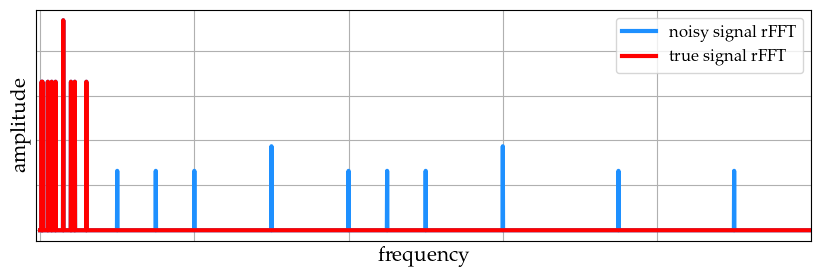

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 3)
ax.plot(noisy_FFT_x, np.abs(noisy_FFT_y), '-', label = 'noisy signal rFFT', linewidth=3, c="dodgerblue")
ax.plot(noisy_FFT_x, np.abs(True_FFT_y), '-',  label = 'true signal rFFT', linewidth=3, c="red")
ax.set_xlabel('frequency') # , labelpad = 20); # fontsize = label_FontSize,
ax.set_ylabel('amplitude') # , fontsize = 20) # , labelpad=20); # fontsize = label_FontSize,
ax.tick_params(axis='y', which='major') # , labelsize = 15) #) #
ax.tick_params(axis='x', which='major') # , labelsize = 15) #) #
plt.xlim([-5, 1000])
# plt.ylim([-5, 100])
ax.legend(loc = "upper right"); # , fontsize=20
ax.grid(True);

file_name = plot_dir + "noise_FFT_sineCosine.pdf"
# plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)

# MF Style

### Define Class and plotting function

In [14]:
class one_curve_class:
    def __init__(self, x1, y1, ccolor, leg1, x_label, y_label, x_limits):
        self.x1 = x1
        self.y1 = y1
        self.leg1 = leg1
        self.ccolor = ccolor

        self.x_label = x_label
        self.y_label = y_label
        self.x_limits = x_limits

def plot_1curve_in_1subplot(one_curve_obj):
    # plt.subplots_adjust(left=0, bottom=0, right=1.1, top=0.9, wspace=0, hspace=0)
    # plt.subplots_adjust(wspace=.1, hspace = 0.5)
    plt.subplots_adjust(right = 1.5, top = 1.1)

    ##########################################################################################
    fig, ax1 = plt.subplots()
    fig.set_size_inches(10, 3)
    ax1.grid(True);

    ax1.plot(one_curve_obj.x1, 
             one_curve_obj.y1, 
             '-', 
             linewidth = 3,
             label = one_curve_obj.leg1, 
             c = one_curve_obj.ccolor)

    ax1.set_xlabel(one_curve_obj.y_label) 
    ax1.set_ylabel(one_curve_obj.y_label) # , labelpad=20); # fontsize = label_FontSize,

    ax1.tick_params(axis='y', which='major') #, labelsize = tick_FontSize)
    ax1.tick_params(axis='x', which='major') #,
    ax1.legend(loc="upper right"); # , fontsize=12
    
    plt.xlim(one_curve_obj.x_limits)
    

<Figure size 600x400 with 0 Axes>

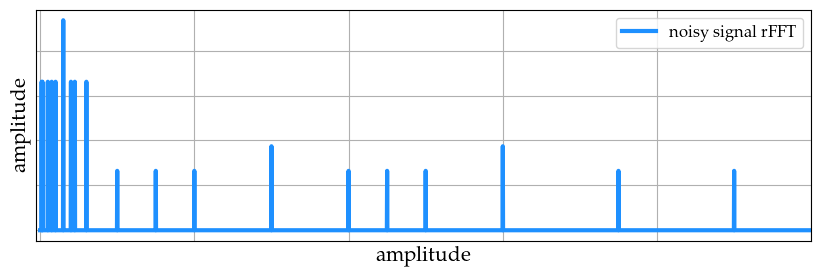

In [15]:
# 
# The following needs to be changed to adapt the new changes
#

one_curv_obj = one_curve_class(x1 = noisy_FFT_x, 
                               y1 = np.abs(noisy_FFT_y), 
                               ccolor = "dodgerblue",
                               leg1 = "noisy signal rFFT", 
                               x_label = "frequency", 
                               y_label = "amplitude", 
                               x_limits = [-5, 1000])

plot_1curve_in_1subplot(one_curv_obj);

## Kill High Frequencies

Read [the source](https://realpython.com/python-scipy-fft/#the-fourier-transform).


#### Here we have to deviate from the website if we want to keep the cosine. Just keep the ones with high values and drop the rest.
But how? when they include imaginary part?

In [16]:
noisy_FFT_y_original = noisy_FFT_y.copy()

In [17]:
noisy_FFT_yRemove = noisy_FFT_y_original.copy()

In [18]:
noisy_FFT_yRemove[np.abs(noisy_FFT_yRemove) < 60000] = 0

/var/folders/0j/hq0rj1017116ysjtk0p16b540000gn/T/ipykernel_3862/3371301051.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-r" (-> color='r'). The keyword argument will take precedence.
  ax.plot(noisy_FFT_x, np.abs(noisy_FFT_yRemove), '-r', label = 'true signal', c="red", linewidth=3)


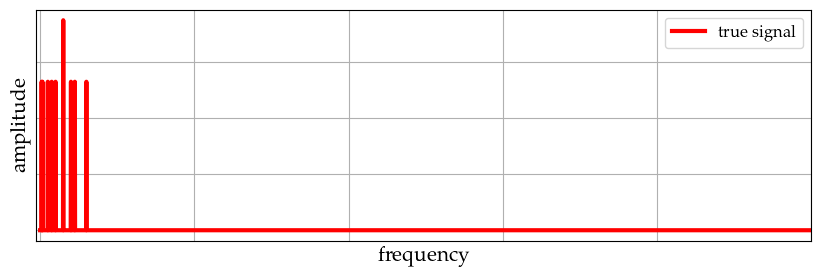

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 3)

ax.plot(noisy_FFT_x, np.abs(noisy_FFT_yRemove), '-r', label = 'true signal', c="red", linewidth=3)
ax.set_xlabel('frequency') #, fontsize = 20); # fontsize = label_FontSize, , labelpad=20
ax.set_ylabel('amplitude') # , fontsize = 20); # fontsize = label_FontSize,labelpad=20
ax.tick_params(axis='y', which='major', labelsize = 15)
ax.tick_params(axis='x', which='major', labelsize = 15)
plt.xlim([-5, 1000])
ax.legend(loc = "upper right"); # , fontsize=20
ax.grid(True);

file_name = plot_dir + "KillNoise_FFT_sineCosine.pdf"
# plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)

# MF Style

<Figure size 600x400 with 0 Axes>

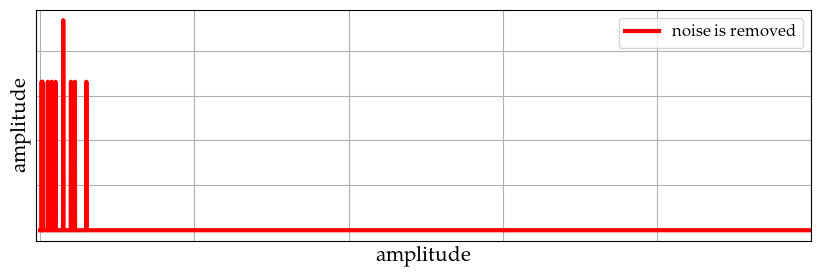

In [22]:
one_curv_obj = one_curve_class(x1 = noisy_FFT_x, 
                               y1 = np.abs(noisy_FFT_yRemove), 
                               ccolor = "red",
                               leg1 = "noise is removed", 
                               x_label = "frequency", 
                               y_label = "amplitude", 
                               x_limits = [-5, 1000]); # limit x-axis for better review!!! 

plot_1curve_in_1subplot(one_curv_obj);

## Apply inverse FFT

In [23]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset

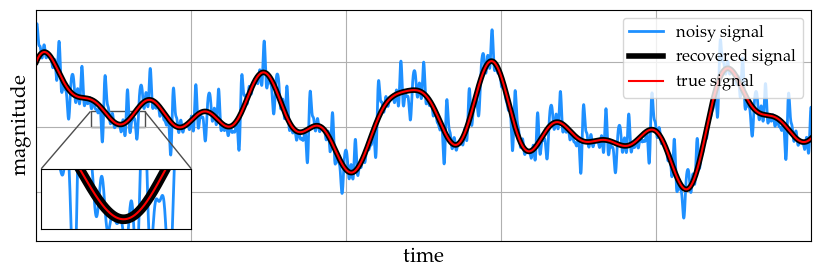

In [28]:
recovered_sig = irfft(noisy_FFT_yRemove)

fig, ax = plt.subplots()
fig.set_size_inches(10, 3)

ax.plot(noisy_tone, linewidth = 2, ls = '-', label = 'noisy signal', c="dodgerblue")
ax.plot(recovered_sig, 'k', ls='-', linewidth = 4, label = 'recovered signal')
ax.plot(nice_tone, '-r', linewidth = 1.5, label = 'true signal')

ax.set_xlabel('time'); # fontsize = (label_FontSize + 5), labelpad=20
ax.set_ylabel('magnitude'); # , fontsize = (label_FontSize + 5), labelpad=20

ax.tick_params(axis = 'y', which = 'major') # , labelsize = (tick_FontSize + 5))
ax.tick_params(axis = 'x', which = 'major') # , labelsize = (tick_FontSize + 5))
ax.set_xlim([0, 10000])

########################
########################  inset plot
########################
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [.693, 0.15, 0.2, 0.2]
left, bottom, width, height = [.13, 0.15, 0.15, 0.2]
ax2 = fig.add_axes([left, bottom, width, height])

ax2.plot(noisy_tone, linewidth = 2, ls='-', label = 'noisy signal', c="dodgerblue")
ax2.plot(recovered_sig, 'k', ls='-', linewidth = 7, label = 'recovered signal')
ax2.plot(nice_tone, '-r', linewidth = 1.5, label = 'true signal')

ax2.set_xlim([700, 1400])
ax2.set_ylim([0, 1.2])

######################################################## inset locator
mark_inset(ax, ax2, loc1 = 1, loc2 = 2, facecolor = "none", edgecolor = "0.3")

########################################################

ax2.set_xticks([])
ax2.set_yticks([])
########################

# plt.xlim([0, 100])

ax.grid(True);
ax.legend(loc = "upper right"); #  fontsize=20 the LaTex part goes crazy sometimes 

file_name = plot_dir + "recoveredSignal_sineCosine.pdf"
# plt.savefig(fname = file_name, dpi=400, bbox_inches='tight', transparent=False)